In [ ]:
# import libraries

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
# set display settings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

In [ ]:
# specify columns, datatypes, and load full consolidated sdss dataset

# load column names from file into a list
sdss_headers = pd.read_csv('../data/processed/sdss_full.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify groups of primary columns
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
class_label_names = ['sdss_clean_class_name', 'stellar_subclass_MK', 'gz2_subclass_hubble']
class_label_codes = ['sdss_clean_class_code', 'stellar_subclass_code', 'gz2_subclass_code']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
galaxy_filters = ['petroR90_r_log']
object_features = ['redshift_log', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)

In [168]:
# create map between class label names and class label codes
sdss_clean_class_map = dict(zip(sdss_primary[class_label_names[0]], sdss_primary[class_label_codes[0]]))
stellar_subclass_map = dict(zip(sdss_primary[class_label_names[1]], sdss_primary[class_label_codes[1]]))
gz2_subclass_map = dict(zip(sdss_primary[class_label_names[2]], sdss_primary[class_label_codes[2]]))
class_code_maps = [sdss_clean_class_map, stellar_subclass_map, gz2_subclass_map]

In [ ]:
# inspect the imported data
 
 # display some data
display(sdss_primary.head(3))
display(sdss_primary.tail(3))
display(sdss_primary.sample(10))
 
# inspect dataframe
print(sdss_primary.shape)
print(sdss_primary.info())

In [ ]:
# investigate superclasses & simplified subclasses (categorical labels)

# create a helper function for investigating and plotting a subset from a column w/ categorical data
def investigate_clean_classes(df, column, filter=None):
    data = df[column]
    if filter:
        data = df[df['sdss_clean_class_name'] == filter][column]
    unclassified_count = data.isna().sum() + (data == 'unclassified').sum() + (data == 'unkonwn').sum()
    print(f"\n---------- {column} : {filter} ----------")
    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")
    print(f"The number of unique labels is: {len(df[column].unique())}")
    data2 = data[data != 'unclassified']
    data2 = data2[data2 != 'unknown']
    plt.figure(figsize=(3, 2))
    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette='viridis')
    #plt.suptitle(f"{column = }")
    #plt.tight_layout()
    plt.show()

investigate_clean_classes(sdss_primary, 'sdss_clean_class_name')
investigate_clean_classes(sdss_primary, 'gz2_subclass_hubble', 'galaxy')
investigate_clean_classes(sdss_primary, 'stellar_subclass_MK', 'star')

In [ ]:
# investigate histograms of feature columns, color-shaded by superclass

# generate a subset dataframe
df = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]
df = df.sample(frac=0.5)

# define classes
classes = sdss_primary['sdss_clean_class_name'].unique()

# set a color palette with distinct colors for each category
colors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))

# iterate over columns and create separate plots
for col in object_features + star_features:
    plt.figure(figsize=(3, 2))
    plt.xscale('linear')
    log_choice = False
    denom = df[col].min()
    if denom == 0:
        denom = 0.001
    if abs(df[col].max() / denom) > 50:
        df[col] = df[col].replace(0, 0.001)
        log_choice = True
        plt.xscale('symlog')  
    for class_label, color in zip(classes, colors):
        if 'elodie' in col:
            if class_label == 'star':
                sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
        else:
            sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
    plt.title(col)
    plt.legend()
    plt.show()

In [166]:
# split dataset into train/test/validation subsets and store column names

X0, X_test, y0, y_test = train_test_split(sdss_primary[object_features], sdss_primary[class_label_codes], test_size = 0.2) #, stratify = sdss_primary[class_label_codes])
X_train, X_val, y_train, y_val = train_test_split(X0, y0, test_size = 0.25)
X_cols = X_train.columns.tolist()
y_cols = y_train.columns.tolist()

In [159]:
# transform the data

# transform he data - apply z-standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [133]:
# manually set weights to each object feature
# NOTE: the weights are determined from physical reasons (i.e. the first feature is from the spectroscopic detector and the other4 features are from the photometric detector)

# specify scalar values and create transformed feature dataset
scalar_values = [0.5, 0.5/4, 0.5/4, 0.5/4, 0.5/4]
X_weighted = X_train[:, :] * scalar_values

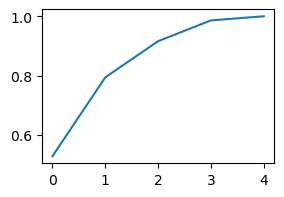

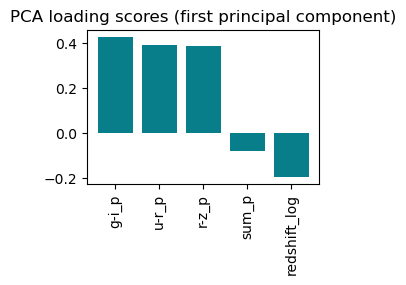

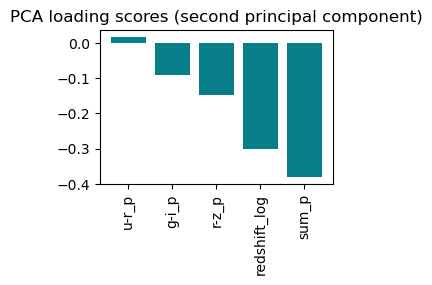

,PC1,PC2,sdss_clean_class_code
387317,1.394242,-0.338515,0
651978,-1.279454,1.038460,2
558081,1.104269,-0.017193,0
218405,1.113589,0.656488,0
331331,0.444592,0.586543,0


/tmp/ipykernel_2419/145451515.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {class_code}', cmap='viridis', s=1, alpha=0.5)


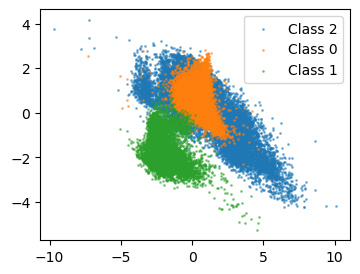

In [122]:
# principal component analysis

# fit the object_identifiers to a PCA model
pca = PCA().fit(X_train)

# plot the cumulative variance by # of principal components
# NOTE: the first PC already explaines ~80% of the total variance in the dataset
plt.figure(figsize=(3,2))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.show()

# evaluate the PCA loadings
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_ratio_), 
    columns=[f'PC{i}' for i in range(1, len(object_features) + 1)],
    index=object_features
)
loadings.head()

# visualize correlations between first PC and object_features
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
plt.figure(figsize=(3,2))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=12)
plt.xticks(rotation='vertical')
plt.show()

# visualize correlations between first PC and object_features
pc1_loadings = loadings.sort_values(by='PC2', ascending=False)[['PC2']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
plt.figure(figsize=(3,2))
plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (second principal component)', size=12)
plt.xticks(rotation='vertical')
plt.show()

# fiting the object_identifiers to a PCA model w/ 2 PC's
X_pca = PCA(n_components=2).fit_transform(X_train)

# make a dataframe to store PC features and label
temp1 = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
temp1.reset_index(drop=True, inplace=True)
temp2 = y_train[[class_label_codes[0]]]
temp2.reset_index(drop=True, inplace=True)
pca_df = pd.concat([temp1, temp2], axis=1)
display(pca_df.sample(5))

# generate a scatterplot of the first two PC's
pca_df = pca_df.sample(frac=0.1)
plt.figure(figsize=(4,3))
for class_code in pca_df[class_label_codes[0]].unique():
    class_data = pca_df[pca_df[class_label_codes[0]] == class_code]
    plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {class_code}', cmap='viridis', s=1, alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# perform hierarchical clustering on a distance matrix

from sklearn.cluster import AgglomerativeClustering

# define the model's functional form
def fit_agglomeration(X, n_clusters):
    model = AgglomerativeClustering(
        n_clusters = n_clusters,
        linkage = 'ward'
    )
    model.fit(X)
    return model

# specify the number of clusters
# NOTE: clusters will be assigned numbers 0, 1, 2
n_clusters = len(y_train['sdss_clean_class_name'].unique())

# generate the model
model = fit_agglomeration(X_train, n_clusters)

# get predictions & add them to the dataframe
sdss_primary['superclass_hierarchical_cluster'] = model.predict(X_train)

In [ ]:
# perform hierarchical clustering on a distance matrix

from sklearn.cluster import FeatureAgglomeration

# define the model's functional form
def fit_agglomeration(X, n_clusters):
    model = FeatureAgglomeration(
        n_clusters = n_clusters,
        linkage = 'ward'
    )
    model.fit(X)
    return model

# specify the number of clusters
# NOTE: clusters will be assigned numbers 0, 1, 2
n_clusters = len(y_train['sdss_clean_class_name'].unique())

# generate the model
model = fit_agglomeration(X_train, n_clusters)

# get predictions & add them to the dataframe
#sdss_primary['superclass_hierarchical_cluster'] = model.predict(X_train)

In [ ]:
# consult the notebook '07 decision trees'

In [131]:
display(print(X_train[0:4,:]))

[[-0.07665797 -0.76817204  0.62784381  0.4137103   0.32235379]
 [ 0.11519304 -0.93954881 -0.4387842  -0.22887753 -0.0179576 ]
 [ 0.29188348 -0.10234231  0.68094696  0.46032093  0.29992326]
 [ 0.03863816 -0.47153947 -0.69714725 -0.62169791 -0.40565665]]


None

In [125]:
# define a helper function to generate a k-means clustering model

# define the model's functional form
def fit_kmeans(X, n_clusters):
    model = KMeans(
        n_clusters = n_clusters,
        init = 'k-means++',
        n_init = 10,
        max_iter = 300,
        tol = 1e-04,
        random_state=0
    )
    model.fit(X)
    return model

In [ ]:
# create a k-means model with 3 clusters (same as number of known superclasses)

# specify the number of clusters
# NOTE: clusters will be assigned numbers 0, 1, 2
n_clusters = len(sdss_primary['sdss_clean_class_name'].unique())

# generate the model and get predictions, based on only redshift_log
model = fit_kmeans(X_train[:,0], n_clusters)
#y_train_0_superclass_kmeans = model.predict(X_train[:,0])



In [ ]:
# visualize results of the model

# display some data
display(sdss_primary[['sdss_clean_class_name', 'superclass_k-means_cluster']].sample(10))

# create a helper function to evaluate accuracy
def evaluate_cluster_accuracy(X, y):
    for label in sdss_primary['sdss_clean_class_name'].unique().tolist():
        print(f"---- {label} ----")
        num_objects = len(sdss_primary[sdss_primary['sdss_clean_class_name'] == label])
        for n in range(n_clusters):
            num_matches = len(sdss_primary[(sdss_primary['sdss_clean_class_name'] == label) & (sdss_primary['superclass_k-means_cluster'] == n)])
            print(f"\t% assigned to cluster {n}: {num_matches / num_objects}")
        
# inspect clustering accuracy
evaluate_cluster_accuracy(3)

# print histogram of cluster counts
counts = sdss_primary.groupby(['sdss_clean_class_name', 'superclass_k-means_cluster']).size().reset_index(name='count')
pivot_table = counts.pivot_table(index='superclass_k-means_cluster', columns='sdss_clean_class_name', values='count', fill_value=0)
sns.set(rc={'figure.figsize':(6,3)})
ax = pivot_table.plot(kind='bar', stacked=True, colormap='viridis')
ax.legend(title='k-means cluster', loc='upper right')

# 

In [193]:
print(type(y_train))
print(y_train[:,0].shape)

<class 'pandas.core.frame.DataFrame'>


InvalidIndexError: (slice(None, None, None), 0)

In [179]:
df = pd.DataFrame({'A': ['a', 'b', 'c', 'a', 'b', 'c'],
                   'B': [1, 2, 3, 1, 2, 3]})

# Create a dictionary mapping values of A to B
mapping_dict = dict(zip(df['A'], df['B']))

# Your original ndarray
original_array = np.array([1, 2, 1, 2, 3])

# Map values using the dictionary
mapped_array = [key for value, key in mapping_dict.items() if value in original_array]

print(mapped_array)

[]


/tmp/ipykernel_2419/1233199278.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mapped_array = [key for value, key in mapping_dict.items() if value in original_array]


In [194]:

# define the model's functional form
def fit_kmeans(X, n_clusters):
    model = KMeans(
        n_clusters = n_clusters,
        init = 'k-means++',
        n_init = 10,
        max_iter = 300,
        tol = 1e-04,
        random_state=0
    )
    model.fit(X)
    return model

# specify the number of clusters
# NOTE: clusters will be assigned numbers 0, 1, 2
n_clusters = len(sdss_primary['sdss_clean_class_name'].unique())

# generate the model and get predictions, based on only redshift_log
model = fit_kmeans(X_train, n_clusters)
y_train_0_superclass_kmeans = model.predict(X_train)


"""temp1 = pd.DataFrame(data=X_pca, columns=['PC1','PC2'])
temp1.reset_index(drop=True, inplace=True)
temp2 = y_train[[class_label_codes[0]]]
temp2.reset_index(drop=True, inplace=True)
pca_df = pd.concat([temp1, temp2], axis=1)"""

# create a helper function to apply the model and evaluate accuracy
def evaluate_cluster_accuracy(X, X_cols, y, n_clusters):
    print(f"\t---{y_col}---")
    model = fit_kmeans(X_train, n_clusters)
    y_pred = model.predict(X_train)
    df_model1 = pd.DataFrame(data=X, columns=X_cols)
    y_label = np.vectorize(class_code_map.get)(y)
    print(y.shape)
    print(type(y))
    df_model2 = pd.DataFrame(data=y, columns=[y_col])
    df_model2b = pd.DataFrame(data=y_label, columns=['actual label'])
    df_model3 = pd.DataFrame(data=y_pred, columns=['prediction'])
    y_pred_label = np.vectorize(class_code_map.get)(y_pred)
    df_model3b = pd.DataFrame(data=y_pred_label, columns=['predicted labels'])
    df_model = pd.concat([df_model1, df_model2, df_model2b, df_model3, df_model3b], axis=1)
    display(df_model.sample(10))
    """for label in sdss_primary[y_col].unique().tolist():
        print(f"---- {label} ----")
        num_objects = len(sdss_primary[sdss_primary[y_col] == label])
        for n in range(n_clusters):
            num_matches = len(sdss_primary[(sdss_primary['sdss_clean_class_name'] == label) & (sdss_primary['superclass_k-means_cluster'] == n)])
            print(f"\t% assigned to cluster {n}: {num_matches / num_objects}")"""
        
# inspect clustering accuracy
evaluate_cluster_accuracy(X_train, X_cols, y_train[class_code_maps[0]], 3)

# print histogram of cluster counts
"""counts = sdss_primary.groupby(['sdss_clean_class_name', 'superclass_k-means_cluster']).size().reset_index(name='count')
pivot_table = counts.pivot_table(index='superclass_k-means_cluster', columns='sdss_clean_class_name', values='count', fill_value=0)
sns.set(rc={'figure.figsize':(6,3)})
ax = pivot_table.plot(kind='bar', stacked=True, colormap='viridis')
ax.legend(title='k-means cluster', loc='upper right')"""

# 

TypeError: Passing a dict as an indexer is not supported. Use a list instead.

In [ ]:
# CONCLUSION: THE ACCURACY IS MUCH HIGHER IF I ONLY INCLUDE REDSHIFT_LOG, AS OPPOSED TO INCLUDING REDSHIFT_LOG + ALL THE PHOTOMETRIC FEATURES
# NEXT STEPS:  1) TRY FINE-TUNING THE MODEL HYPERPARAMETERS, 2) TRY TO REGULARIZE THE MODEL;  3) IF ALL ELSE FAILS, I CAN DO PCA PRIOR TO THE MODELING TO DIMINISH THE IMPORTANCE OF THE PHOTOMETRIC VARIABLES
# FINAL STEPS: MAKE PRETTY PLOTS AND TABLES TO SUMMARIZE